# Homework 4: Perceptrons and Deep Learning [25 pts]
## Comp562 Summer II 2023

### Due 11:59pm July 25, 2023

In this assignment, you will use the perceptron and deep learning models discussed in class and experiment with some toy data. To avoid unexpected behavior with cached variables, always test your code with a fresh kernel. For hardware acceleration, use Colab with GPU enabled.

### Problem 1: Perceptron and MLP Model [5 pts]
**(1a)** Compare and contrast the perceptron model with SVM and linear regression. [3 pts]

The linear regression models the relationship between input features and the target  variable. Linear regression uses residuals to predict values. Least squared optimization is used to find the optimal linear equation. Linear regression is better for discrete class labels instead of classification task. 

Support vector machine uses a hyperplane to maximize the minimum distance between a point and hyperplane. SVM can handle non-linearly and linearly seperable data. SVM is used for classification and regression. 

The perceptron model learns decision boundaries based on iretaively upadting the weight of input features based on misclassification errors. The perceptron model works best on linearly seperable data (it makes the assumption the data is linearly seperable). The perceptron model is used for classification task.

**(1b)** What is the purpose of nonlinear activations? [2 pts]

Nonlinear activations expand neural network capabilities by enabling the modeling of nonlinear realationships.

### Problem 2: LSTM [10 pts]
**(2a)** Why are long-term dependencies hard to model with standard recurrent neural networks? [2 pts]

Long-term dependencies are hard to model with standard recurrent neural networks because gradients either go to zero or go to infinity. As a result, it doesn't effectively update parameters to learn long-range dependencies. 

**(2b)** Submit your modified sonnet generation code in a separate Gradescope assignment [4 pts]. (Completion, no answer required here.)

The following questions relate to your sonnet generation model.

**(2c)** Justify your choice of model architectures and the changes you made to the model architecture from the provided code. [2 pts]

For this model I did hyperparameter/parameter changes. I didn't directlly alter the model architecture. I made changes to the dropout rate, batch size, sequence length, and epochs. Differences to the 

**(2d)** Jusify any other changes you made to the sonnet generation code. [1 pt]

- I lowered the dropout rate to .3,a higher dropout rate increases variance. I figured a lower dropout rate would increase the models ability to fit properly.
- I reduced the batch_size to 64,this reduces the samples to calculate the loss in each iteration. I mostly did this to reduce training time. 
- I reduced the seq_length to 50, In my test it seemed that the shorter sequences performed better with my other parameters.
- I increased the n_epochs to 50, I did this by trial and error and saw what epocj size fit the the best.

**(2e)** Analyze the sample sonnets generated from your model. Are they realistic? Given unlimited computing power, what modifications would you make to improve their quality? [1 pt]

The sample sonnet I gennerated is semi-realistic aside from some words that aren't english/old english. It follows the look of a sonnet and the stylistic text of a sonnet. 

### Problem 3: Convolutional Neural Networks [10 pts]

**(3a)** Load the torchvision [CIFAR10 dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10). Design and train a model to perform 10-class classification on this dataset. Implementations that use models loaded from torch hub will not recieve full credit. Your model should improve over a baseline accuracy of 40%. [6 pts]

In [13]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

'''
References:
https://flower.dev/docs/framework/example-pytorch-from-centralized-to-federated.html
https://machinelearningmastery.com/building-a-convolutional-neural-network-in-pytorch/
'''

#Transformation using: https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])

#Load data using: https://www.datascienceweekly.org/tutorials/cifar10-pytorch-load-cifar10-dataset-from-torchvision
trainloader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform),
    batch_size=128, shuffle=True
)

testloader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform),
    batch_size=128, shuffle=False
)

#CNN for classification
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

#GPU tutorial: https://wandb.ai/wandb/common-ml-errors/reports/How-To-Use-GPU-with-PyTorch---VmlldzozMzAxMDk
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.7)

#Train model
num_epochs = 10
train_loss = []
val_loss = []

for epoch in range(num_epochs):
    running_train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs = data[0].to(device) 
        labels = data[1].to(device)

        optimizer.zero_grad()
        loss = criterion(model(inputs), labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()


    #Avg loss ~ Al
    avg_tl = running_train_loss / len(trainloader)
    train_loss.append(avg_tl)

    #Val loss ~ Vl
    with torch.no_grad():
      running_vl = sum(criterion(model(images.to(device)), labels.to(device)).item() for images, labels in testloader)

    #Calculate avg Vl for each epoch
    avg_vl = running_vl / len(testloader)
    val_loss.append(avg_vl)

    print(f"Epoch {epoch + 1} - Train Loss: {avg_tl:.4f}, Val Loss: {avg_vl:.4f}")
print("Completed Training")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1 - Train Loss: 1.8741, Val Loss: 1.6229
Epoch 2 - Train Loss: 1.5260, Val Loss: 1.4455
Epoch 3 - Train Loss: 1.3912, Val Loss: 1.3432
Epoch 4 - Train Loss: 1.2945, Val Loss: 1.2693
Epoch 5 - Train Loss: 1.2147, Val Loss: 1.1968
Epoch 6 - Train Loss: 1.1440, Val Loss: 1.1367
Epoch 7 - Train Loss: 1.0821, Val Loss: 1.0900
Epoch 8 - Train Loss: 1.0332, Val Loss: 1.0523
Epoch 9 - Train Loss: 0.9885, Val Loss: 1.0242
Epoch 10 - Train Loss: 0.9568, Val Loss: 0.9877
Completed Training


**(3b)** Plot your training and validation losses. (Hint: provided code demonstrates usage of labels in plt plotting. You will likely want to modify the plotting function to scale validation appropriately.) [1 pt]

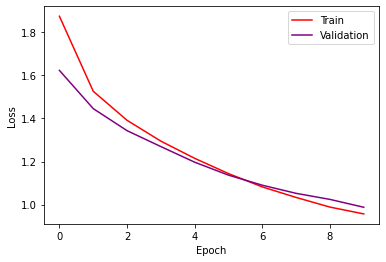

In [14]:
import matplotlib.pyplot as plt

# TODO: track losses for plotting
plt.figure()
plt.plot(train_loss, label='Train', color="red")
plt.plot(val_loss, label='Validation', color="purple")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**(3c)** Evaluate your model on the test partition. [1 pt]

In [15]:
# TODO: test partition evaluation
correct, total = 0, 0

with torch.no_grad():
    correct += sum((torch.max(model(images), 1)[1] == labels).sum().item() for images, labels in testloader)
    total += len(testloader.dataset)

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 65.56%


**(3d)** Justify your choice of model architecture. [2 pts]

- Used this resource: https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/
- I have three convolutional layers
    - I tested two verse three convolutional layers and three convolutional layers performed better. (I assume this because more convolutional layers could capture more hierarchical features)
    - A batch normalization is after each convolutional layer. The batch normalization normalizes activation in each mini-batch
- I added a ReLU activation to add non-linearity to the model (If the model is non-linear then the ReLU captures more complex patterns)
    - Max pooling is applied to each ReLU activation to downsample the data and "speed up" the model. 
- Fully connected layers (Added these because of this article I read: https://medium.com/@media.deepneuron/training-series-3-b2cb53411e4c)
- I added a dropout layer that regularlizes the neural network by setting neurons to zero. (I tested 0.3, 0.5, and 0.8 as probabilities and 0.3 performed the best)